# Tutorial 07

## fitting tests pure CMB

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.methods.fit import *
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 50
APOSCALE = 6.
LMIN = 30
LMAX = 210
PSBIN = 90
FREQS = [23,95,150,353]
FWHM = [np.deg2rad(52.8/60.),np.deg2rad(19./60.),np.deg2rad(11./60.),np.deg2rad(4.94/60.)]
KWARGS = {'nlive':1000}

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])

mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
fidcmb = np.empty((NSAMP,3,mapcmb.shape[1]),dtype=np.float32)
for i in range(NSAMP):
    fidcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

### pure CMB signal

iter: 1687 | +400 | bound: 1 | nc: 1 | ncall: 14732 | eff(%): 14.166 | loglstar:   -inf < -34.637 <    inf | logz: -37.766 +/-  0.094 | dlogz:  0.001 >  0.409                                        

G $\chi^2_{min}$ 69.27388737684299


iter: 1704 | +400 | bound: 1 | nc: 1 | ncall: 14920 | eff(%): 14.102 | loglstar:   -inf < -35.145 <    inf | logz: -38.319 +/-  0.096 | dlogz:  0.001 >  0.409                                        

HL $\chi^2_{min}$ 70.29041180158053
CPU times: user 53min 20s, sys: 10.2 s, total: 53min 30s
Wall time: 7min 3s


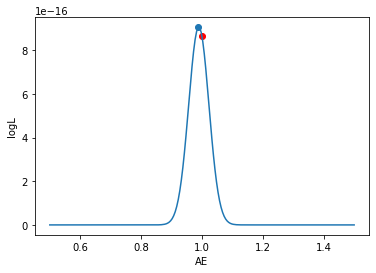

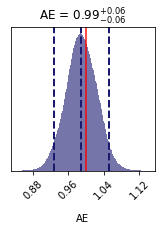

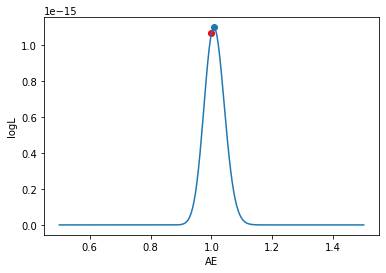

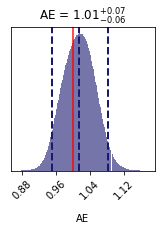

In [2]:
%%time

TARGET = 'E'
MODEL = 'acmb'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

posAE = np.linspace(0.5,1.5,200)
loglAEg = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEg))
ax.scatter(posAE[np.where(loglAEg == np.amax(loglAEg))],np.exp(np.amax(loglAEg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

loglAEh = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEh))
ax.scatter(posAE[np.where(loglAEh == np.amax(loglAEh))],np.exp(np.amax(loglAEh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

iter: 2169 | +400 | bound: 3 | nc: 1 | ncall: 15640 | eff(%): 16.426 | loglstar:   -inf < -1.222 <    inf | logz: -5.596 +/-  0.129 | dlogz:  0.001 >  0.409                                          

G $\chi^2_{min}$ 2.4442404872217245


iter: 2209 | +400 | bound: 3 | nc: 1 | ncall: 15720 | eff(%): 16.597 | loglstar:   -inf < -1.226 <    inf | logz: -5.704 +/-  0.132 | dlogz:  0.001 >  0.409                                          

HL $\chi^2_{min}$ 2.4518955599534973
CPU times: user 53min 17s, sys: 17.1 s, total: 53min 34s
Wall time: 7min 3s


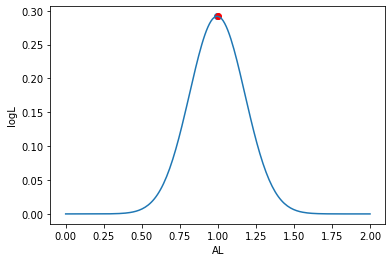

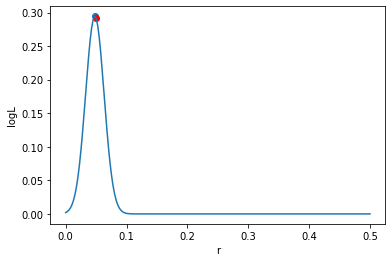

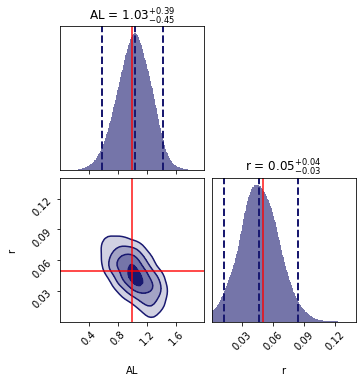

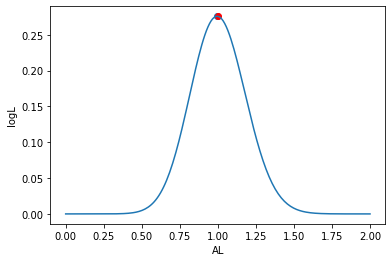

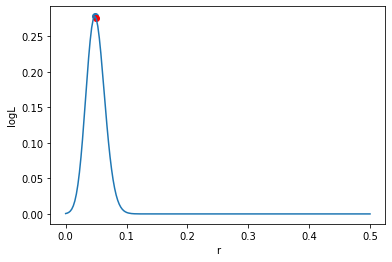

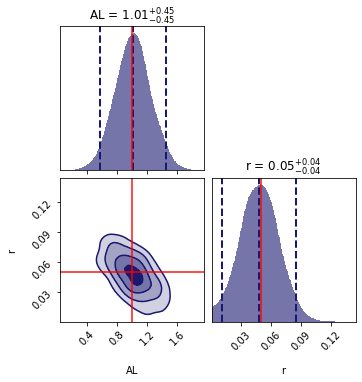

In [3]:
%%time

TARGET = 'B'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

posAL = np.linspace(0,2,200)
loglALg = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALg))
ax.scatter(posAL[np.where(loglALg == np.amax(loglALg))],np.exp(np.amax(loglALg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AL': 1.})
posR = np.linspace(0,0.5,200)
loglRg = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRg))
ax.scatter(posR[np.where(loglRg == np.amax(loglRg))],np.exp(np.amax(loglRg)))
ax.scatter(0.05,np.exp(loglg0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

pp.engine.background.reset({'AE': 1.})
loglALh = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALh))
ax.scatter(posAL[np.where(loglALh == np.amax(loglALh))],np.exp(np.amax(loglALh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AL': 1.})
loglRh = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRh))
ax.scatter(posR[np.where(loglRh == np.amax(loglRh))],np.exp(np.amax(loglRh)))
ax.scatter(0.05,np.exp(loglh0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

iter: 3405 | +400 | bound: 8 | nc: 1 | ncall: 18471 | eff(%): 20.600 | loglstar:   -inf < -35.866 <    inf | logz: -43.374 +/-  0.184 | dlogz:  0.001 >  0.409                                        

G $\chi^2_{min}$ 71.73218293292292


iter: 3435 | +400 | bound: 8 | nc: 1 | ncall: 18925 | eff(%): 20.264 | loglstar:   -inf < -36.388 <    inf | logz: -43.987 +/-  0.185 | dlogz:  0.001 >  0.409                                        

HL $\chi^2_{min}$ 72.77673450876705
CPU times: user 1h 17min 58s, sys: 26.4 s, total: 1h 18min 24s
Wall time: 10min 22s


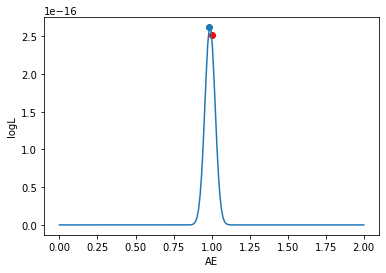

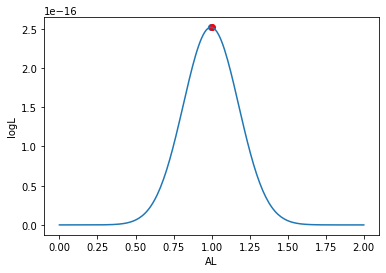

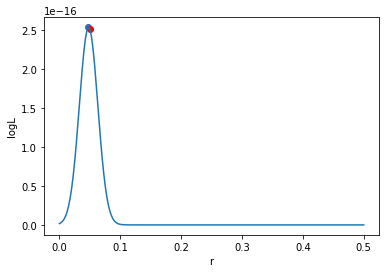

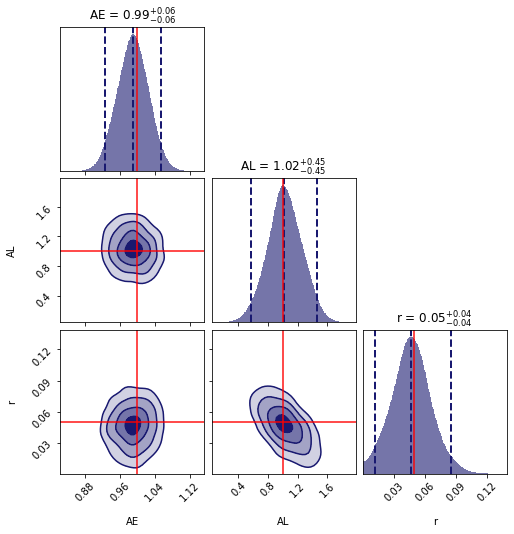

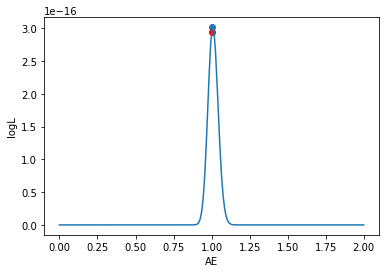

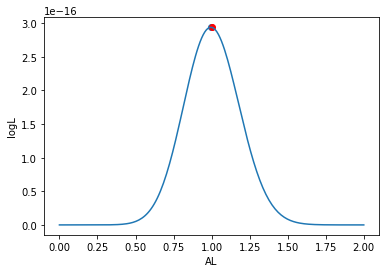

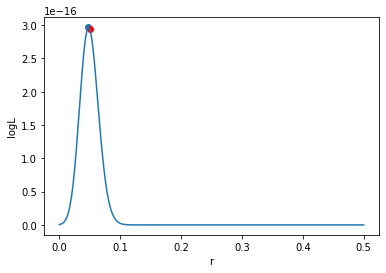

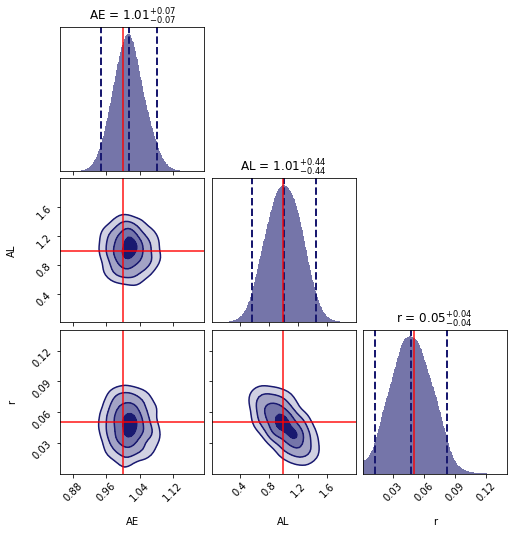

In [4]:
%%time

TARGET = 'EB'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

#
posAE = np.linspace(0,2,200)
loglAEg = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEg))
ax.scatter(posAE[np.where(loglAEg == np.amax(loglAEg))],np.exp(np.amax(loglAEg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
posAL = np.linspace(0,2,200)
loglALg = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALg))
ax.scatter(posAL[np.where(loglALg == np.amax(loglALg))],np.exp(np.amax(loglALg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
posR = np.linspace(0,0.5,200)
loglRg = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRg))
ax.scatter(posR[np.where(loglRg == np.amax(loglRg))],np.exp(np.amax(loglRg)))
ax.scatter(0.05,np.exp(loglg0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

loglAEh = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEh))
ax.scatter(posAE[np.where(loglAEh == np.amax(loglAEh))],np.exp(np.amax(loglAEh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
loglALh = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALh))
ax.scatter(posAL[np.where(loglALh == np.amax(loglALh))],np.exp(np.amax(loglALh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
loglRh = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRh))
ax.scatter(posR[np.where(loglRh == np.amax(loglRh))],np.exp(np.amax(loglRh)))
ax.scatter(0.05,np.exp(loglh0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

end